# Hackerton: Sales Prediction

## related modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME') + '/aiffel/1C_sales_pred'
train_data_path = join(data_dir, 'sales_train.csv')
sub_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(sub_data_path)

/home/aiffel-dj53/aiffel/1C_sales_pred/sales_train.csv
/home/aiffel-dj53/aiffel/1C_sales_pred/test.csv


In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (2935849, 6)
sub data dim : (214200, 3)


In [4]:
data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [254]:
sub.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## 학습셋은   [date, date_block_num, shop_id, item_id, item_price, item_cnt_day]
## 테스트셋은 [ID, shop_id, item_id]로 이루어져있다.
## 현재 우리가 예측해야하는 항목은 월별 매출 (monthly item_cnt_day) 이므로 양쪽 데이터셋을 전처리해야할것같다.

## - 친절하게도 학습데이터에서 date_block_num열에 각년도의 월별로 number index를 지정해주었다. 우리는 월별 데이터가 필요하지, 세세한 일자별 데이터는 불필요하므로  date항목을 지워준다

In [255]:
x = data['date']
del data['date']

### - item_cnt_day가 타겟 데이터가되니 이 역시 지워준다.

In [256]:
y = data['item_cnt_day']
del data['item_cnt_day']

In [257]:
z = data['date_block_num']
del data['date_block_num']

In [258]:
xyz = data['item_price']
del data['item_price']

In [259]:
data ##현시점 학습 데이터 셋 shape

,shop_id,item_id
0,59,22154
1,25,2552
2,25,2552
3,25,2554
4,25,2555
...,...,...
2935844,25,7409
2935845,25,7460
2935846,25,7459
2935847,25,7440


In [260]:
print(len(data))

2935849


In [261]:
sub ## 현시점 테스트 데이터 셋 shape

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [262]:
print(len(sub))

214200


### 우선 테스트 데이터셋이 가진 ID {shop_id, item_id}를 학습 데이터셋에 추가해줘야 할 것 같다.

In [263]:
new_data = pd.merge(data, sub, on=['shop_id', 'item_id']) #merge(원하는 열을 넣을 데이터, 참조할 데이터, on = 참조할 열)
new_data

,shop_id,item_id,ID
0,59,22154,150983
1,25,2574,56520
2,25,2574,56520
3,25,2574,56520
4,25,2574,56520
...,...,...,...
1224434,25,7327,58974
1224435,25,7315,57353
1224436,25,7409,58431
1224437,25,7409,58431


In [264]:
data = pd.DataFrame(new_data, columns = ['ID','shop_id','item_id'])
data
print(len(data))

1224439


### ㄴ 성공적으로 학습셋에 ID를 삽입하였다.

In [265]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

1438639


In [266]:
data.head()

,ID,shop_id,item_id
0,150983,59,22154
1,56520,25,2574
2,56520,25,2574
3,56520,25,2574
4,56520,25,2574


## 결측치 확인

<AxesSubplot:>

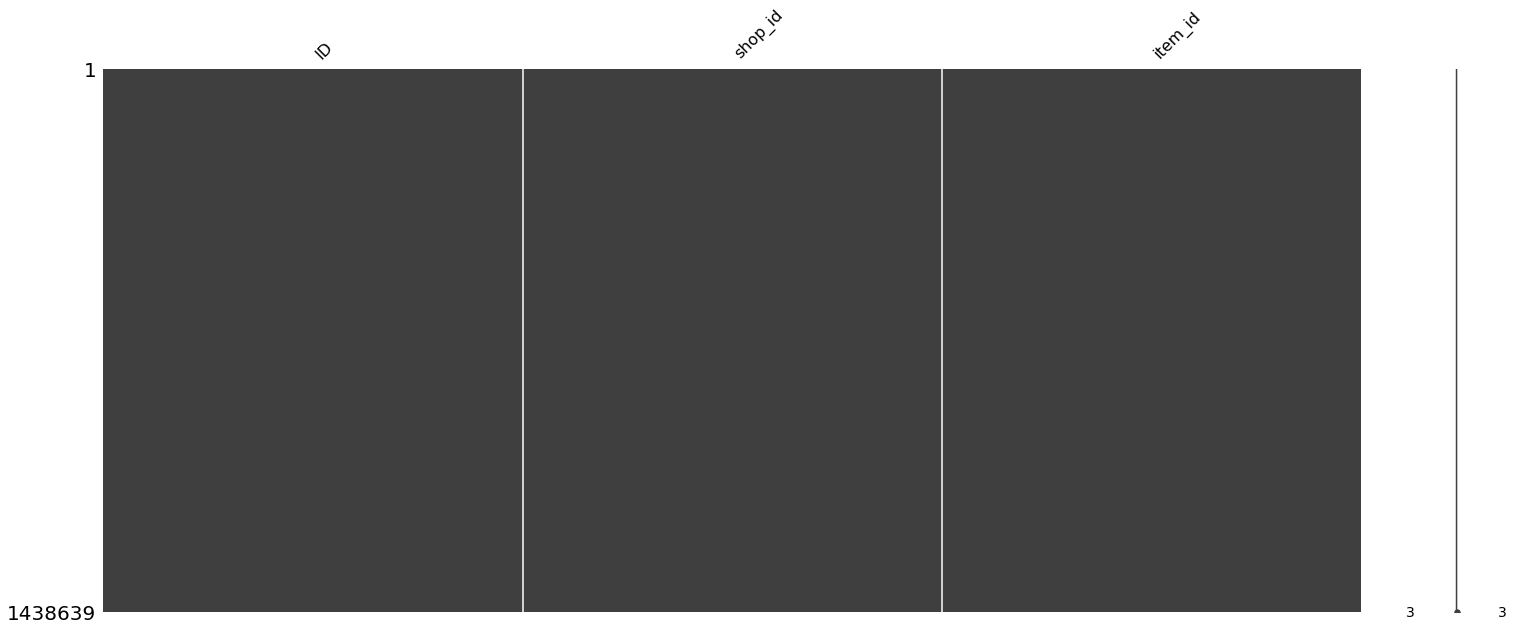

In [267]:
msno.matrix(data)

In [268]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

ID : 0
shop_id : 0
item_id : 0


### ㄴ결측치가 존재한다. merge함수를 이용하여 필요 행을 병합했더니 data셋에 없는 조합이 들어가며 결측이 발생한것같다.

In [269]:
print('전체 데이터 건수:', len(data))

전체 데이터 건수: 1438639


In [270]:
print('컬럼별 결측치 개수')
len(data)-data.count()

컬럼별 결측치 개수


ID         0
shop_id    0
item_id    0
dtype: int64

## #결측치 제거

In [271]:
df_data = data.dropna(axis=0)

In [272]:
for c in df_data.columns:
    print('{} : {}'.format(c, len(df_data.loc[pd.isnull(df_data[c]), c].values)))

ID : 0
shop_id : 0
item_id : 0


In [273]:
print('전체 데이터 건수:', len(df_data))

전체 데이터 건수: 1438639


In [274]:
print('컬럼별 결측치 개수')
len(df_data)-df_data.count()

컬럼별 결측치 개수


ID         0
shop_id    0
item_id    0
dtype: int64

### ㄴ 결측치가 모두 제거되었다.

## #변수 분포 확인

In [275]:
df_data.shape

(1438639, 3)

IndexError: index 3 is out of bounds for axis 0 with size 3

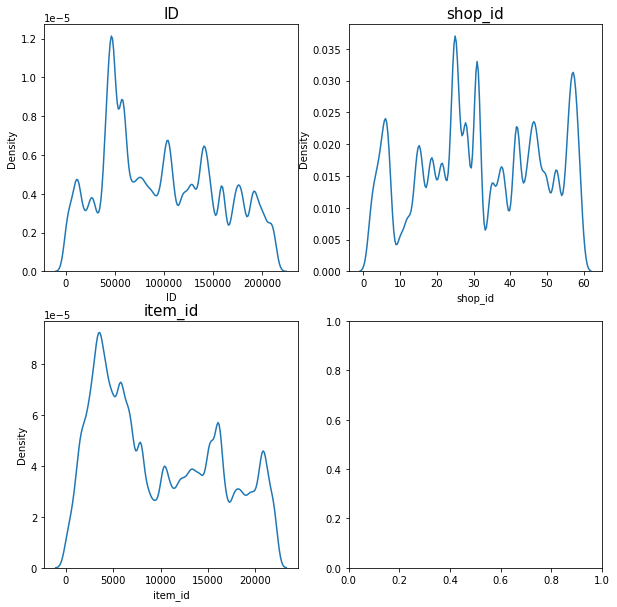

In [277]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = df_data.columns
for row in range(3):
    for col in range(2):
        sns.kdeplot(df_data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1

In [213]:
skew_columns = ['item_price']

for c in skew_columns:
    df_data[c] = np.log1p(df_data[c].values)

print('얍💢')

얍💢


IndexError: index 5 is out of bounds for axis 0 with size 5

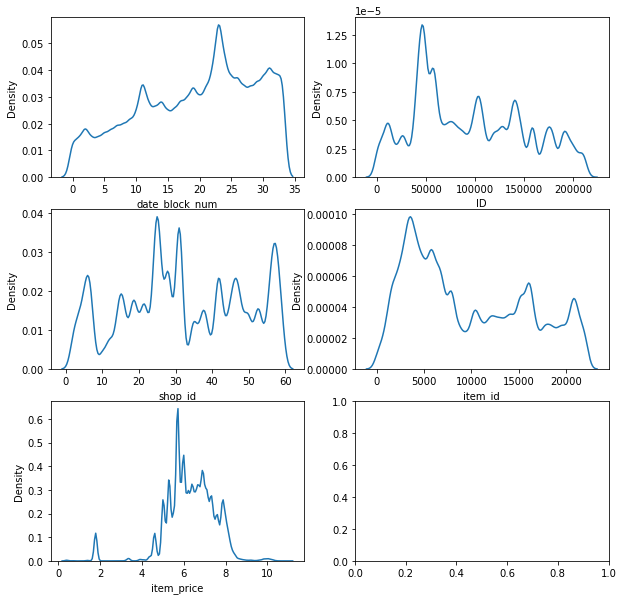

In [214]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = df_data.columns
for row in range(3):
    for col in range(2):
        sns.kdeplot(df_data[columns[count]], ax=ax[row][col])
        count += 1

In [278]:
sub = df_data.iloc[train_len:, :]
x = df_data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(1224439, 3)
(214200, 3)


In [279]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


In [280]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))
print('얍💢')

얍💢


In [281]:
get_cv_score(models)

ValueError: Found input variables with inconsistent numbers of samples: [1224439, 2935849]